--- מעבד מאפיינים גלובליים (GC, Symmetry, Complexity) לקובץ: train1.csv ---
מחשב מדדים...
✅ נתונים נשמרו לקובץ: global_analysis_train1.csv

=== השוואה: Top 20% vs Bottom 20% (Global Features) ===


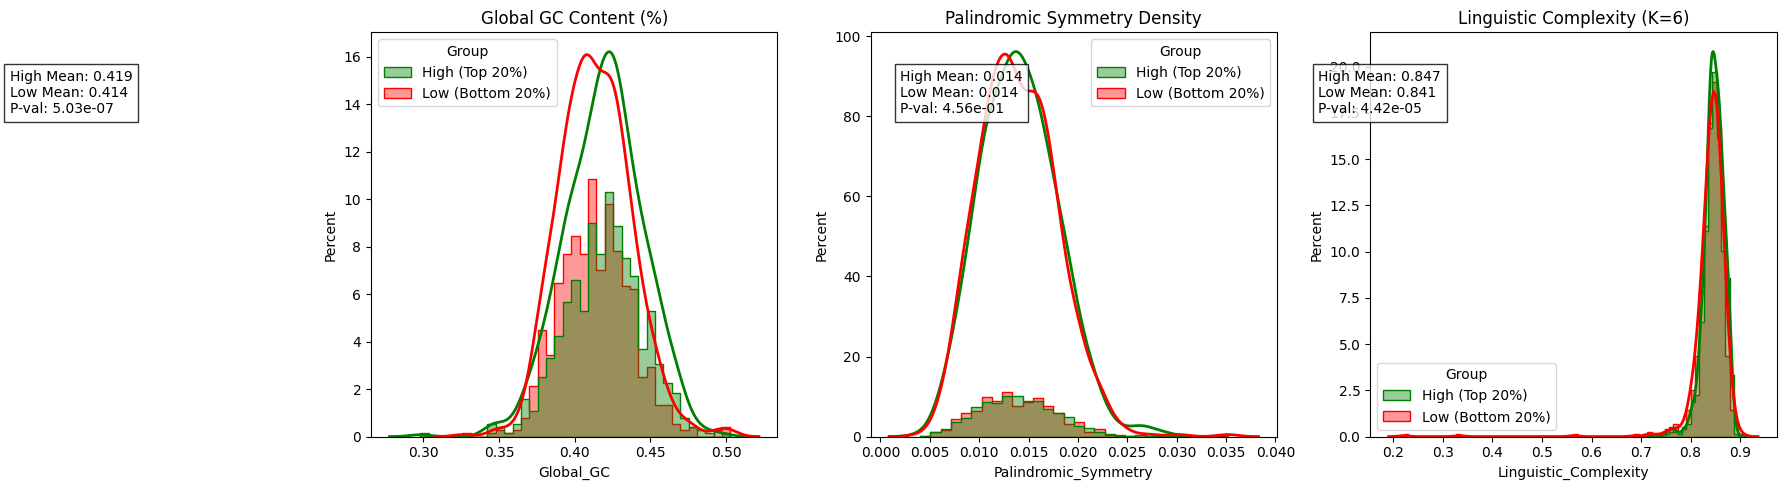


--- סיכום מסקנות גלובליות ---
- GC Content: מובהק. גנים חזקים הם בעלי GC גבוה יותר.
- Complexity: גנים חזקים הם 'עשירים' יותר במידע (מורכבות גבוהה).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# ==========================================
# 1. פונקציות עזר (מחרוזות)
# ==========================================

def get_reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N': 'N'}
    return "".join(complement.get(base, base) for base in reversed(seq))

def calculate_linguistic_complexity(seq, k=6):
    """
    מחשב את היחס בין מספר ה-Kmers הייחודיים
    לבין סך כל ה-Kmers האפשריים ברצף באורך כזה.
    """
    if len(seq) < k: return 0
    
    # אוסף את כל ה-Kmers ברצף
    observed_kmers = set()
    total_kmers_in_seq = len(seq) - k + 1
    
    for i in range(total_kmers_in_seq):
        observed_kmers.add(seq[i:i+k])
    
    # החישוב: כמה מצאנו בפועל חלקי המקסימום התיאורטי שאפשר לדחוף לרצף באורך כזה
    # (או 4 בחזקת K, הנמוך מביניהם)
    max_possible = min(4**k, total_kmers_in_seq)
    
    return len(observed_kmers) / max_possible

def calculate_symmetry_density(seq, window=6):
    """
    מחשב כמה פלינדרומים (רצפים שזהים ל-RC של עצמם) יש ברצף.
    זהו מדד לסימטריה ביולוגית (אתרי קישור).
    """
    palindrome_count = 0
    total_windows = len(seq) - window + 1
    
    for i in range(total_windows):
        sub = seq[i:i+window]
        if sub == get_reverse_complement(sub):
            palindrome_count += 1
            
    # מנרמלים לאורך הרצף (צפיפות)
    return palindrome_count / total_windows if total_windows > 0 else 0

# ==========================================
# 2. פונקציית הניתוח הגלובלי
# ==========================================

def analyze_global_features(row):
    seq = row['promoter']
    
    # 1. Global GC Content
    # חישוב פשוט: (G+C)/Total
    if len(seq) == 0: return pd.Series([0,0,0], index=['Global_GC', 'Palindromic_Symmetry', 'Linguistic_Complexity'])
    
    gc_content = (seq.count('G') + seq.count('C')) / len(seq)
    
    # 2. Palindromic Symmetry
    # נשתמש בחלון של 6 (אופייני לאתרי קישור)
    symmetry_score = calculate_symmetry_density(seq, window=6)
    
    # 3. Linguistic Complexity
    # נשתמש ב-K=6 (4096 צירופים אפשריים, נותן רזולוציה טובה לרצף של 1000)
    complexity_score = calculate_linguistic_complexity(seq, k=6)
    
    return pd.Series({
        'Global_GC': gc_content,
        'Palindromic_Symmetry': symmetry_score,
        'Linguistic_Complexity': complexity_score
    })

# ==========================================
# 3. ניהול הרצה
# ==========================================

def run_global_analysis(csv_path):
    # שם קובץ דינמי
    base_name = os.path.splitext(os.path.basename(csv_path))[0]
    output_csv = f"global_analysis_{base_name}.csv"
    
    print(f"--- מעבד מאפיינים גלובליים (GC, Symmetry, Complexity) לקובץ: {csv_path} ---")
    try:
        df = pd.read_csv(csv_path)
        if 'promoter' not in df.columns:
             df.columns = ['promoter', 'mrna_level'] + list(df.columns[2:])
    except:
        print("שגיאה בטעינת הקובץ.")
        return None

    # חילוץ הפיצ'רים
    print("מחשב מדדים...")
    global_features = df.apply(analyze_global_features, axis=1)
    final_df = df.join(global_features)
    
    # חישוב אחוזונים
    final_df['expression_percentile'] = final_df['mrna_level'].rank(pct=True) * 100
    
    # שמירה
    final_df.to_csv(output_csv, index=False)
    print(f"✅ נתונים נשמרו לקובץ: {output_csv}")
    
    # הפקת גרפים
    plot_global_stats(final_df)
    
    return final_df

def plot_global_stats(df):
    print("\n=== השוואה: Top 20% vs Bottom 20% (Global Features) ===")
    
    high_group = df[df['expression_percentile'] >= 80].copy()
    low_group = df[df['expression_percentile'] <= 20].copy()
    
    # איזון
    min_size = min(len(high_group), len(low_group))
    high_bal = high_group.sample(n=min_size, random_state=42)
    low_bal = low_group.sample(n=min_size, random_state=42)
    
    high_bal['Group'] = 'High (Top 20%)'
    low_bal['Group'] = 'Low (Bottom 20%)'
    combined = pd.concat([high_bal, low_bal])
    
    features = [
        ('Global_GC', 'Global GC Content (%)'),
        ('Palindromic_Symmetry', 'Palindromic Symmetry Density'),
        ('Linguistic_Complexity', 'Linguistic Complexity (K=6)')
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    conclusions = []
    
    for i, (col, title) in enumerate(features):
        ax = axes[i]
        
        # היסטוגרמה רציפה
        sns.histplot(data=combined, x=col, hue='Group', 
                     stat="percent", common_norm=False, element="step",
                     palette={'High (Top 20%)': 'green', 'Low (Bottom 20%)': 'red'}, 
                     ax=ax, alpha=0.4)
        
        # קו KDE להחלקת התמונה
        try:
            sns.kdeplot(data=high_bal, x=col, color='green', ax=ax, lw=2)
            sns.kdeplot(data=low_bal, x=col, color='red', ax=ax, lw=2)
        except:
            pass # במקרה של שונות 0
            
        ax.set_title(title)
        
        # סטטיסטיקה
        mean_high = high_bal[col].mean()
        mean_low = low_bal[col].mean()
        stat, p_val = stats.mannwhitneyu(high_bal[col], low_bal[col])
        
        stats_text = (f"High Mean: {mean_high:.3f}\n"
                      f"Low Mean: {mean_low:.3f}\n"
                      f"P-val: {p_val:.2e}")
        
        y_lim = ax.get_ylim()[1]
        x_lim = ax.get_xlim()[1]
        
        ax.text(x_lim*0.05, y_lim*0.80, stats_text, 
                bbox=dict(facecolor='white', alpha=0.8))

        # לוגיקת מסקנות
        if p_val < 0.05:
            if col == 'Global_GC':
                trend = "נמוך" if mean_high < mean_low else "גבוה"
                conclusions.append(f"GC Content: מובהק. גנים חזקים הם בעלי GC {trend} יותר.")
            elif col == 'Linguistic_Complexity':
                if mean_high > mean_low:
                    conclusions.append("Complexity: גנים חזקים הם 'עשירים' יותר במידע (מורכבות גבוהה).")
    
    plt.tight_layout()
    plt.show()
    
    print("\n--- סיכום מסקנות גלובליות ---")
    if not conclusions:
        print("לא נמצאו הבדלים מובהקים במדדים הגלובליים.")
    for c in conclusions:
        print(f"- {c}")

# ==========================================
# הפעלה
# ==========================================
df_global = run_global_analysis('train1.csv')

--- מעבד מאפיינים גלובליים (GC, Symmetry, Complexity) לקובץ: train2.csv ---
מחשב מדדים...
✅ נתונים נשמרו לקובץ: global_analysis_train2.csv

=== השוואה: Top 20% vs Bottom 20% (Global Features) ===


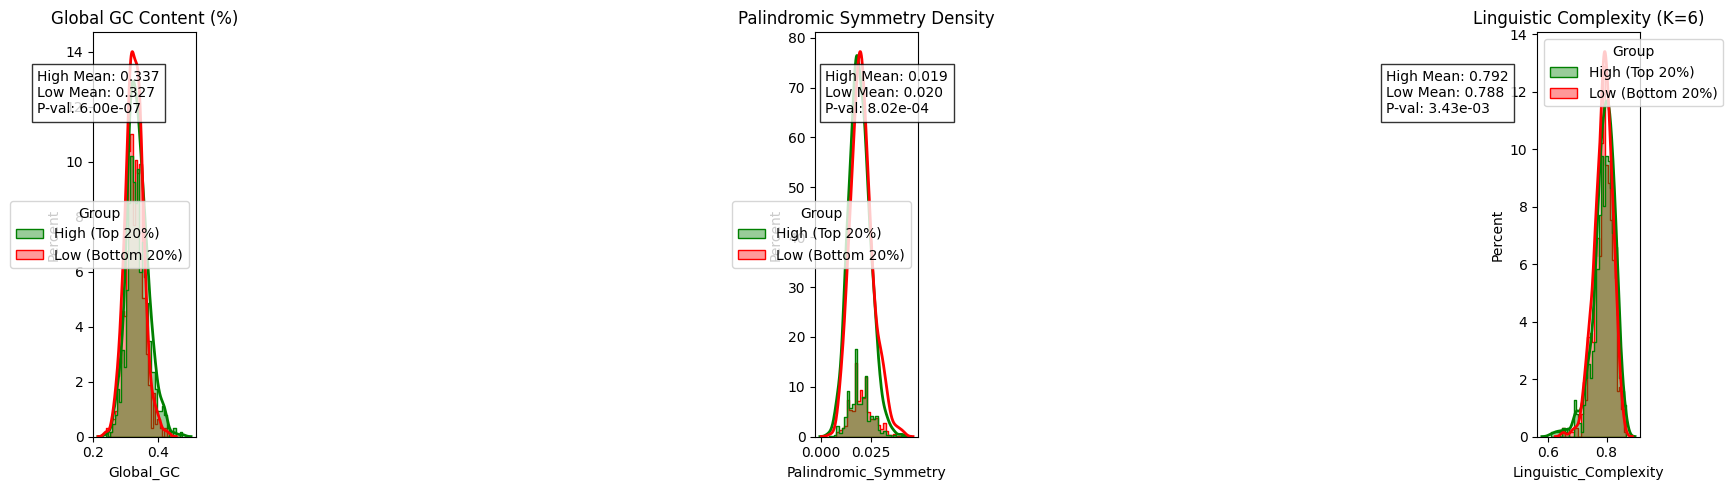


--- סיכום מסקנות גלובליות ---
- GC Content: מובהק. גנים חזקים הם בעלי GC גבוה יותר.
- Complexity: גנים חזקים הם 'עשירים' יותר במידע (מורכבות גבוהה).


In [2]:
df_global2 = run_global_analysis('train2.csv')

In [3]:
def calculate_effect_size(df, feature_cols):
    print("\n=== בדיקת 'האם זה בכלל מעניין?' (Effect Size Analysis) ===")
    
    # חלוקה לקבוצות קיצון (20/80)
    high = df[df['expression_percentile'] >= 80]
    low = df[df['expression_percentile'] <= 20]
    
    results = []
    
    for col in feature_cols:
        # חישוב ממוצעים וסטיות תקן
        m1, m2 = high[col].mean(), low[col].mean()
        s1, s2 = high[col].std(), low[col].std()
        
        # חישוב Cohen's d
        # הנוסחה: ההפרש בין הממוצעים חלקי סטיית התקן המשותפת
        pooled_std = np.sqrt((s1**2 + s2**2) / 2)
        if pooled_std == 0: 
            d = 0
        else:
            d = abs(m1 - m2) / pooled_std
            
        # פרשנות מילולית
        if d < 0.2: impact = "זניח (רעש)"
        elif d < 0.5: impact = "קטן (חלש)"
        elif d < 0.8: impact = "בינוני (סביר)"
        else: impact = "גדול (מצוין!)"
        
        results.append({
            'Feature': col,
            'High_Mean': m1,
            'Low_Mean': m2,
            'Cohen_d': d,
            'Verdict': impact
        })
    
    # הצגה כטבלה מסודרת
    results_df = pd.DataFrame(results).sort_values(by='Cohen_d', ascending=False)
    print(results_df)
    return results_df

# --- הרצה על הפיצ'רים הגלובליים ---
# (הנחה: df_global הוא הדאטה-פריים שיצרת בשלב הקודם)
features_to_check = ['Global_GC', 'Palindromic_Symmetry', 'Linguistic_Complexity']
calculate_effect_size(df_global, features_to_check)


=== בדיקת 'האם זה בכלל מעניין?' (Effect Size Analysis) ===
                 Feature  High_Mean  Low_Mean   Cohen_d     Verdict
0              Global_GC   0.419244  0.413639  0.227433   קטן (חלש)
2  Linguistic_Complexity   0.847111  0.840560  0.210961   קטן (חלש)
1   Palindromic_Symmetry   0.014093  0.013951  0.036266  זניח (רעש)


,Feature,High_Mean,Low_Mean,Cohen_d,Verdict
0,Global_GC,0.419244,0.413639,0.227433,קטן (חלש)
2,Linguistic_Complexity,0.847111,0.840560,0.210961,קטן (חלש)
1,Palindromic_Symmetry,0.014093,0.013951,0.036266,זניח (רעש)


In [4]:
calculate_effect_size(df_global2, features_to_check)


=== בדיקת 'האם זה בכלל מעניין?' (Effect Size Analysis) ===
                 Feature  High_Mean  Low_Mean   Cohen_d     Verdict
0              Global_GC   0.336950  0.326956  0.326893   קטן (חלש)
1   Palindromic_Symmetry   0.019321  0.020462  0.209992   קטן (חלש)
2  Linguistic_Complexity   0.791938  0.788274  0.104418  זניח (רעש)


,Feature,High_Mean,Low_Mean,Cohen_d,Verdict
0,Global_GC,0.336950,0.326956,0.326893,קטן (חלש)
1,Palindromic_Symmetry,0.019321,0.020462,0.209992,קטן (חלש)
2,Linguistic_Complexity,0.791938,0.788274,0.104418,זניח (רעש)
